## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Preprocess test dataset](#Preprocess)
6. [Modelling](#Modelling)
7. [Making predictions of the test set and creating a submission file](#Predictions)


<a name="Libraries"></a>
## 1. Importing libraries


In [3]:
# Import libraries
import requests
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [44]:
# Load files
train = pd.read_csv('train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


In [45]:
# Preview test dataset
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000


In [46]:
# Check size and shape of datasets
train.shape, test.shape, 

((297177, 7), (127361, 6))

<a name="Statistics"></a>
## 3. Statistical summaries

In [47]:
# Train statistical summary
train.describe(include = 'all')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177,297177,293563.00000,293563.00000,293628.00000,293628.00000,297177.00000
unique,297177,293751,NaN,NaN,NaN,NaN,NaN
top,ID_QF0ZTQJ2SF5Q,2021-11-26 17:23:00,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-21 07:34:57,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.75120,38.18302,23.31655,78.65362,0.37107
std,NaN,NaN,28.52618,28.64776,3.83697,14.77272,0.48309
min,NaN,NaN,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,NaN,NaN,22.43000,19.52000,20.40000,68.00000,0.00000


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from *2021-10-15 16:00:34* to *2022-01-21 07:34:57*
 - There is a high correlation between Sensor1_PM2.5	and Sensor2_PM2.5
 - Minimum recorded temperature is *16.70000* and a maximum *34.90000*

In [48]:
# Check for missing values
print('missing values:', train.isnull().sum())

missing values: ID                      0
Datetime                0
Sensor1_PM2.5        3614
Sensor2_PM2.5        3614
Temperature          3549
Relative_Humidity    3549
Offset_fault            0
dtype: int64


<a name="Missing"></a>
## 4. Missing values and duplicates

In [20]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any() 

(False, True)

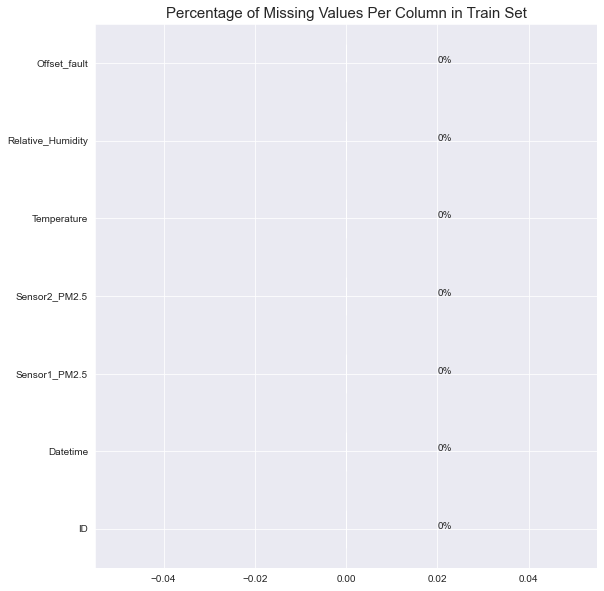

In [21]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [22]:
# Fill missing values with zeros
train = train.fillna(0)

In [23]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

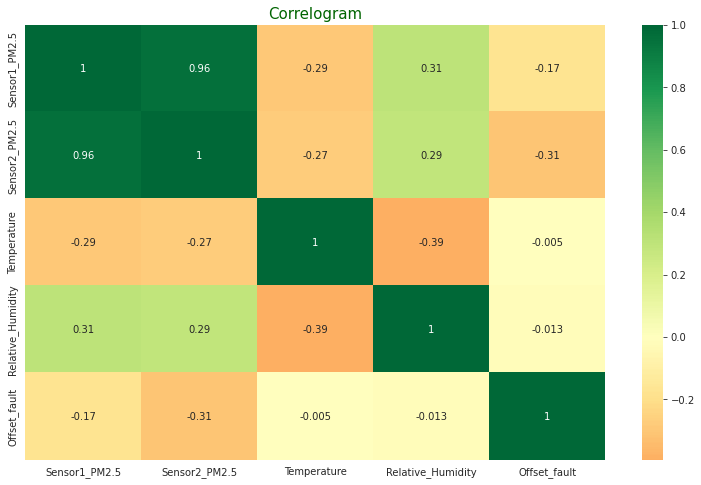

In [ ]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

- There is a 0.96 positive correlation between sensor1 PM2.5 and sensor2 PM2.5
- There is a -0.99 negative correlation between temperature and humidity

<a name="Preprocess"></a>
## 5.  Preprocess test dataset

In [51]:
train['Datetime_day'] = train.Datetime.dt.day
train['Datetime_month'] =train.Datetime.dt.month
train['Datetime_year'] = train.Datetime.dt.year
train['Datetime_hour'] =train.Datetime.dt.hour
train_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5','Temperature',	'Relative_Humidity','Datetime_day','Datetime_month','Datetime_year','Datetime_hour']

X = train[train_feats]

X['Sensor1_PM2.5']=X['Sensor1_PM2.5'].fillna(int(X['Sensor1_PM2.5'].median()))
X['Sensor2_PM2.5']=X['Sensor2_PM2.5'].fillna(int(X['Sensor2_PM2.5'].median()))
X['Temperature']=X['Temperature'].fillna(int(X['Temperature'].median()))
X['Relative_Humidity']=X['Relative_Humidity'].fillna(int(X['Relative_Humidity'].median()))
y = train.Offset_fault
X = X.fillna(0)

In [53]:
X.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,52.58000,49.52000,17.40000,96.00000,3,11,2021,4
1,35.25000,33.40000,25.00000,75.00000,8,11,2021,18
2,19.18000,23.50000,24.90000,75.00000,7,11,2021,9
3,19.40000,15.48000,24.90000,70.00000,1,1,2022,18
4,38.30000,34.77000,20.90000,89.00000,5,11,2021,22


In [54]:
# Extract day, month and year from the Datetime column

test['Datetime_day'] = test.Datetime.dt.day
test['Datetime_month'] = test.Datetime.dt.month
test['Datetime_year'] = test.Datetime.dt.year
test['Datetime_hour'] = test.Datetime.dt.hour

# Fill in missing values with Zeroes
test = test.fillna(0)

# Preview engineered test set
test_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5','Temperature',	'Relative_Humidity','Datetime_day','Datetime_month','Datetime_year','Datetime_hour']
test=test[test_feats]
test.head()

,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour
0,90.75000,114.78000,22.20000,56.00000,28,1,2022,8
1,56.03000,52.18000,0.00000,0.00000,16,2,2022,21
2,387.35000,346.73000,28.10000,63.00000,24,1,2022,17
3,63.17000,83.85000,21.60000,82.00000,31,1,2022,7
4,69.23000,53.07000,22.70000,80.00000,31,1,2022,0


<a name="Modelling"></a>
## 6.  Modelling

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, classification_report
from sklearn.svm import SVC


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


##   Random Forest model

In [2]:

# Instantiating the model
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

NameError: name 'RandomForestClassifier' is not defined

## SVM Model

In [65]:
# Instantiating the model
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)
#Making predictions
y_pred = classifier.predict(X_test)
# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

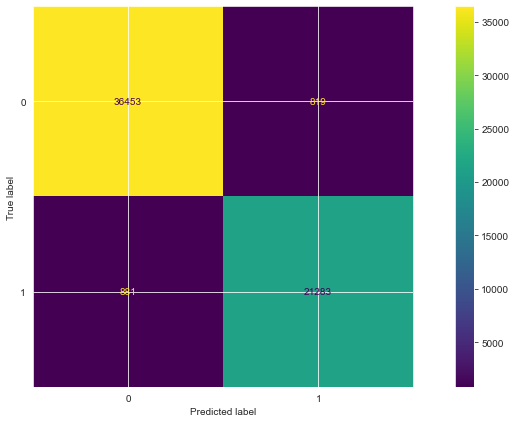

In [63]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

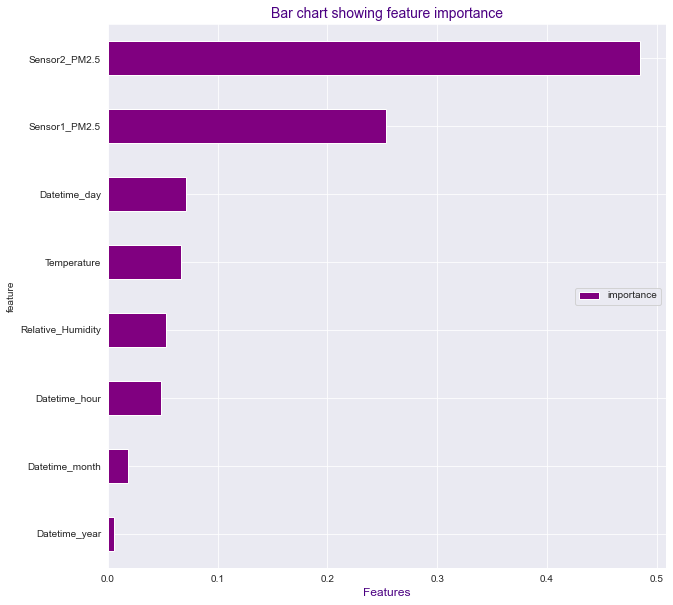

In [64]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

<a name="Predictions"></a>
## 7. Making predictions of the test set and creating a submission file

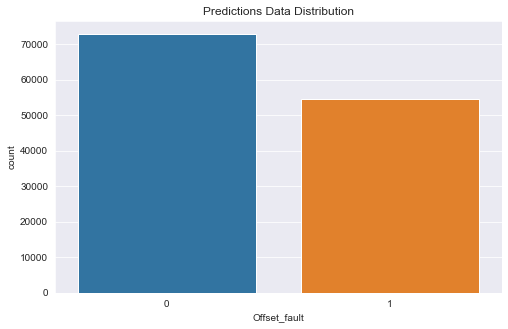

In [62]:
# Make prediction on the test set
test_df = test[train_feats]
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

 - Majority of the model predictions are 0

In [1]:
sub_file.to_csv('Baseline.csv', index=False)

NameError: name 'sub_file' is not defined